In [124]:
from collections import Counter
from stop_words import get_stop_words
from nltk.stem import PorterStemmer
from nltk.stem import LancasterStemmer
import re
import matplotlib.pyplot as plt
import pandas
import numpy as np
import string
import networkx as nx
import warnings
warnings.filterwarnings("ignore")
fs = open('./amazon-meta_sample.txt', 'r', encoding='utf8', errors='ignore')
(Id, ASIN, Title, SalesRank, Group, Categories, Similar, Reviews, Ratings)=("","","",0,"","","",0,0.0)
products = {}; Books = {}; Music = {}; Videos = {};

In [125]:
#For normalization, convert to lower, remove punctuations, digits, stopwords, and 1-2 length words
def geNormalizedText(string):
    string = string.lower()
    string = re.sub(r'[^\w\s]|\d+|\b\w{1,2}\b',' ',string)
    string = ' '.join(set(string.split())-set(get_stop_words("english")))
    return string

#Functions to return top n frequent collection from any group
def keyfunc(k):
    return count[k]

def maxNSoldItem(count, n):
    counterMap = {}
    for key in sorted(count, key=keyfunc, reverse=True)[:n]:
        counterMap[key] = count[key]
    return counterMap

In [126]:
#reading lines from the file and creating a products dictionary obj with asin as key and metadata as its value
for line in fs:
    MetaData = {}
    line = line.strip()
    if line.startswith("Id",0):
        Id = line[3:].strip()
    elif line.startswith("ASIN",0):
        ASIN = line[5:].strip()
    elif line.startswith("title",0):
        Title = line[7:].strip()
    elif line.startswith("group",0):
        Group = line[6:].strip()
    elif line.startswith("salesrank",0):
        SalesRank = line[10:].strip()
    elif line.startswith("reviews"):
        ls = line.split()
        Reviews = ls[2].strip()
        Ratings = ls[7].strip()
    elif(line.startswith("categories")):
        ls = line.split()
        Categories = ' '.join((fs.readline()).lower() for i in range(int(ls[1].strip())))
        Categories = geNormalizedText(Categories)
    elif line.startswith("similar",0):
        ls = line.split()
        Similar = ' '.join([similar for similar in ls[2:]])        
    elif len(line) == 0:
        MetaData['Id'] = Id
        MetaData['Title'] = Title
        MetaData['Group'] = Group
        MetaData['SalesRank'] = SalesRank
        MetaData['Categories'] = Categories
        MetaData['Similar'] = Similar
        MetaData['Reviews'] = Reviews
        MetaData['Ratings'] = float(Ratings)
        if ASIN != "": products[ASIN]= MetaData
        (Id, ASIN, Title, SalesRank, Group, Categories, Similar, Reviews, Ratings)=("","","",0,"","","",0,0.0)
fs.close()

Videos:  384
Books:  5695
Music:  1566


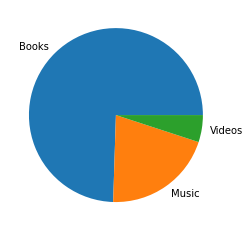

In [131]:
MostSoldBooks = []
MostSoldMusic = []
MostSoldVideos = []
BooksWithBetterReviews = {}
MostRatedBooks = {}
rated_1_2 = []
rated_2_3 = []
rated_3_4 = []
rated_4_5 = []
for asin,metadata in products.items():
    if(metadata['Group'] == 'Book'):
        Books[asin] = products[asin]  
        for i in metadata['Similar'].split():
            MostSoldBooks.append(i.strip())
        BooksWithBetterReviews[asin] = int(metadata['Reviews'])
        rating = float(metadata['Ratings'])
        MostRatedBooks[asin] = rating
        if rating > 1 and rating <= 2:
            rated_1_2.append(asin)
        elif rating > 2 and rating <= 3:
            rated_2_3.append(asin)
        elif rating > 3 and rating <= 4:
            rated_3_4.append(asin)
        elif rating >4 and rating <= 5:
            rated_4_5.append(asin) 
    if(metadata['Group'] == 'Music'):
        Music[asin] = products[asin]
        for i in metadata['Similar'].split():
            MostSoldMusic.append(i.strip())
    if(metadata['Group'] == 'Video'):
        Videos[asin] = products[asin]
        for i in metadata['Similar'].split():
            MostSoldVideos.append(i.strip())
print("Videos: ",len(Videos))
print("Books: ",len(Books))
print("Music: ",len(Music))
CategoriesCounter = [len(Books),len(Music),len(Videos)]
#plt.hist(CategoriesCounter, bins=3)
plt.pie(CategoriesCounter, labels=["Books","Music","Videos"])
ax = plt.show()

In [ ]:
#top 3 Music based on Reviews
sorted(Music.items(), key=lambda x: x[1]['Reviews'], reverse=True)[:3]

In [ ]:
#top 3 Books based on Reviews
sorted(Books.items(), key=lambda x: x[1]['Reviews'], reverse=True)[:3]

In [ ]:
#top 3 Videos based on Reviews
sorted(Videos.items(), key=lambda x: x[1]['Reviews'], reverse=True)[:3]

Understanding the word Normalization:

In [ ]:
porter = PorterStemmer()
lancaster=LancasterStemmer()
#proide a word to be stemmed
print("Porter Stemmer")
print(porter.stem("Christianity"))
print(porter.stem("Sprituality"))
print(porter.stem("Clergy"))
print(porter.stem("earth"))
print(porter.stem("am"))
print("Lancaster Stemmer")
print(lancaster.stem("Christianity"))
print(lancaster.stem("Sprituality"))
print(lancaster.stem("Clergy"))
print(lancaster.stem("earth"))

We can find the Categories similarity. Similarity can determine how ‘close’ two pieces of text are both 
in surface closeness(lexical similarity) and meaning(semantic similarity).
We can use Cosine Similarity here for categories as here we only want to match the common words and this 
eventually would help us in calculating the similarity. 0 means dissimilar, towards 1 means more similar.

Text(0.5, 1.0, 'Top 10 Videos')

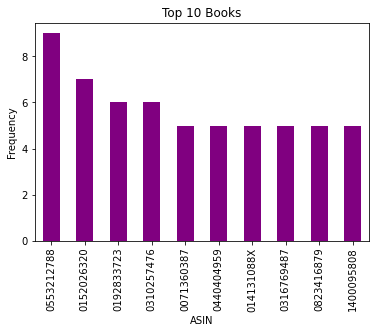

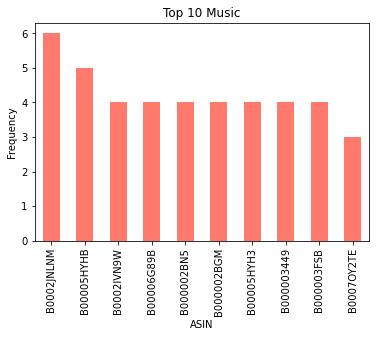

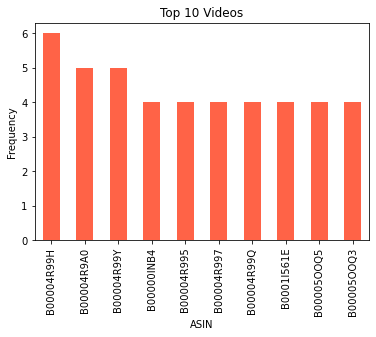

In [132]:
#Top 10 items from respective groups with ASIN details;
count = Counter(MostSoldBooks)
#count = Counter(Similars).most_common(10)
df = pandas.DataFrame.from_dict(maxNSoldItem(count, 10), orient='index')
ax = df.plot(kind='bar', legend=False, color='purple')
ax.set_xlabel("ASIN")
ax.set_ylabel("Frequency")
ax.set_title("Top 10 Books")

count = Counter(MostSoldMusic)
#count = Counter(Similars).most_common(10)
df = pandas.DataFrame.from_dict(maxNSoldItem(count, 10), orient='index')
ax = df.plot(kind='bar', legend=False, color='#FF796C')
ax.set_xlabel("ASIN")
ax.set_ylabel("Frequency")
ax.set_title("Top 10 Music")

count = Counter(MostSoldVideos)
#count = Counter(Similars).most_common(10)
df = pandas.DataFrame.from_dict(maxNSoldItem(count, 10), orient='index')
ax = df.plot(kind='bar', legend=False, color='#FF6347')
ax.set_xlabel("ASIN")
ax.set_ylabel("Frequency")
ax.set_title("Top 10 Videos")

[('0807220280', 5539), ('0939173379', 4921), ('0385504209', 3049), ('1590073991', 1688), ('0451191145', 1244), ('0736605673', 992), ('0764585789', 709), ('0694525790', 698), ('0399214240', 681), ('038550926X', 631)]


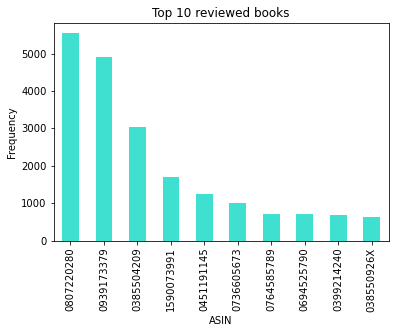

In [133]:
#Top 10 Books with most reviews

count = Counter(BooksWithBetterReviews)
df = pandas.DataFrame.from_dict(maxNSoldItem(count, 10), orient='index')
ax = df.plot(kind='bar', legend=False, color='turquoise')
ax.set_xlabel("ASIN")
ax.set_ylabel("Frequency")
ax.set_title("Top 10 reviewed books")

print(count.most_common(10))

[('0827229534', 5.0), ('0486287785', 5.0), ('0871318237', 5.0), ('3895780812', 5.0), ('0895872218', 5.0), ('0439240751', 5.0), ('1573221740', 5.0), ('0590568833', 5.0), ('0944708498', 5.0), ('0613100093', 5.0)]
Books rated b'n 1-2:  49
Books rated b'n 2-3:  304
Books rated b'n 3-4:  1204
Books rated b'n 4-5:  2445


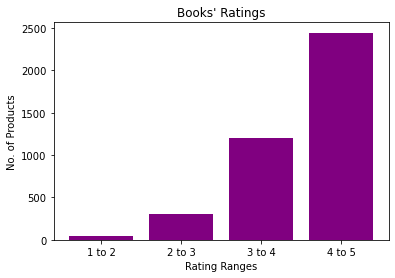

In [137]:
#Top 10 rated books 
count = Counter(MostRatedBooks).most_common(10)
print(count)

#how many books are rated from 1 t0 5, in range(1-2, 2-3, 3-4, 4-5) ?

print("Books rated b'n 1-2: ", len(rated_1_2))
print("Books rated b'n 2-3: ", len(rated_2_3))
print("Books rated b'n 3-4: ", len(rated_3_4))
print("Books rated b'n 4-5: ", len(rated_4_5))

BookRatingsByRange = [len(rated_1_2),len(rated_2_3),len(rated_3_4),len(rated_4_5)]
plt.bar(["1 to 2","2 to 3","3 to 4","4 to 5"],BookRatingsByRange, color='purple')
plt.xlabel("Rating Ranges")
plt.ylabel("No. of Products")
plt.title("Books' Ratings")
plt.show()

In [138]:
for asin,metadata in Books.items():
    Books[asin]['Similar'] = ' '.join([n for n in metadata['Similar'].split() if n in Books.keys()])

In [139]:
from operator import itemgetter
import networkx as nx
from networkx.algorithms import community

In [140]:
#Prepare the nodeList & edgeList
G = nx.Graph()

In [142]:
#Preparing the node list for Graph:
_asin = []
_similar = []
_reviews = []
_ratings = []
for asin,metadata in products.items():
    if(metadata['Group'] == 'Book'):
        #data.append(products[asin],len(metadata['Similar']),metadata['Reviews'],metadata['Ratings'])
        _asin.append(asin)
        _similar.append(len(metadata['Similar']))
        _reviews.append(metadata['Reviews'])
        _ratings.append(metadata['Ratings'])
dict = {'ASIN':_asin, 'Similar':_similar,'Reviews':_reviews,'Ratings':_ratings}
df = pd.DataFrame(dict)
df.to_csv('nodeList.csv', index = False)

#Preparing the edge list for Graph:
_source = []
_target = []
#_weights = similarity coefficient
for asin,metadata in products.items():
    if(metadata['Group'] == 'Book'):
        for _asinRest in range(len(metadata['Similar'])):
            _source.append(asin)
            _target.append(metadata['Similar'][_asinRest])
dict = {'Source':_source, 'Target':_target}
df = pd.DataFrame(dict)
df.to_csv('edgeList.csv', index = False)

In [143]:
import csv
node_names = []
edges = []
with open('nodeList.csv', 'r') as nodecsv:
    nodereader = csv.reader(nodecsv)
    nodes = [n for n in nodereader][1:]

# Get a list of just the node names (the first item in each row)
node_names = [n[0] for n in nodes]

# Read in the edgelist file
with open('edgeList.csv', 'r') as edgecsv:
    edgereader = csv.reader(edgecsv)
    edges = [tuple(e) for e in edgereader][1:]

# Print the number of nodes and edges in our two lists
print(len(node_names))
print(len(edges))

5695
1847


In [144]:
G.add_nodes_from(node_names) # Add nodes to the Graph
G.add_edges_from(edges) # Add edges to the Graph
print(nx.info(G))

# Create an empty dictionary for each attribute
similar_dict = {}
reviews_dict = {}
ratings_dict = {}

for node in nodes: # Loop through the list of nodes, one row at a time
    similar_dict[node[0]] = node[1] # Access the correct item, add it to the corresponding dictionary
    reviews_dict[node[0]] = node[2]
    ratings_dict[node[0]] = node[3]

# Add each dictionary as a node attribute to the Graph object
nx.set_node_attributes(G, similar_dict, 'similar_purchase')
nx.set_node_attributes(G, reviews_dict, 'reviews')
nx.set_node_attributes(G, ratings_dict, 'ratings')

Name: 
Type: Graph
Number of nodes: 5707
Number of edges: 1161
Average degree:   0.4069


In [145]:
#network density. This is simply the ratio of actual edges in the network to all possible edges in the network.
#By displaying the number of connections (known as degree, see below) as the size of nodes.
density = nx.density(G)
print("Network density:", density)

Network density: 7.130542545846902e-05


#On a scale of 0 to 1, not a very dense network. A 0 would mean that there are no connections at all, 
#and a 1 would indicate that all possible edges are present (a perfectly connected network): 
#this network is on the lower end of that scale, but still far from 0.

In [146]:
print(nx.is_connected(G))
#False, means this graph as more than one component
#Component - Connected Graph

False


In [147]:
# Next, use nx.connected_components to get the list of components,
# then use the max() command to find the largest one:
components = nx.connected_components(G)
largest_component = max(components, key=len)
#print(components)
print(len(largest_component))

189


In [156]:
# Create a "subgraph" of just the largest component
# Then calculate the diameter of the subgraph.
subgraph = G.subgraph(largest_component)
diameter = nx.diameter(subgraph)
print("Network diameter of largest component:", diameter)

Network diameter of largest component: 4


In [149]:
G1 = nx.Graph()
for asin,metadata in Books.items():
    #add the node, ASIN
    G1.add_node(asin)
    categories = set((Books[asin]['Categories']).split())
    similar_purchased = metadata['Similar'].split()
    for s in similar_purchased:
        s = s.strip()
        G1.add_node(s)
        similarPurchasedCategories = set((Books[s]['Categories']).split())
        similarity = len(categories.union(similarPurchasedCategories))>0 and  round(len(categories.intersection(similarPurchasedCategories)) / len(categories.union(similarPurchasedCategories)),2) or 0
        G1.add_edge(asin, s, weight=similarity)
degree = nx.degree(G1)
for asin in nx.nodes(G1):
    Books[asin]['Degree'] = int(degree[asin])
print(nx.info(G1))

Name: 
Type: Graph
Number of nodes: 5695
Number of edges: 146
Average degree:   0.0513
